In [15]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（同じ縮退ペア間のみ）
w3 = 0.2      # 3体相互作用（全てのトリプレット間）

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義（フェルミ符号を含む） ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン ====
pairs = [(0,1), (2,3), (4,5)]
H2 = np.zeros((dim, dim))

for (a,b) in pairs:
    for i, s in enumerate(basis):
        # 密度項（両方占有）
        if s[a] == 1 and s[b] == 1:
            H2[i, i] += v

        # 交換項 a→b
        if s[a] == 1 and s[b] == 0:
            s2, sign = apply_cdag_c(s, b, a)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

        # 交換項 b→a（逆方向も入れる）
        if s[b] == 1 and s[a] == 0:
            s2, sign = apply_cdag_c(s, a, b)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

# ==== 3体ハミルトニアン ====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

# 全ての triplet → triplet 結合を入れる
for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            # T2をすべて占有している場合のみ作用
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # まず T2 をアニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # 次に T1 を作る
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = H # Hermitize（実対称に）

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.3 1.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  2.3 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.3 2.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  2.3 0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  3.  0.3 0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 3.  0.  0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  3.  0.3 0.  0.  0.  0.  0.3 0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.3 3.  0.  0.  0.  0.  0.  0.3 0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  4.3 0.  0.  0.  0.  0.  0.3 0.  0.
  0.  0. ]
 [0.2 0.  0.  0.  0.3 0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  3

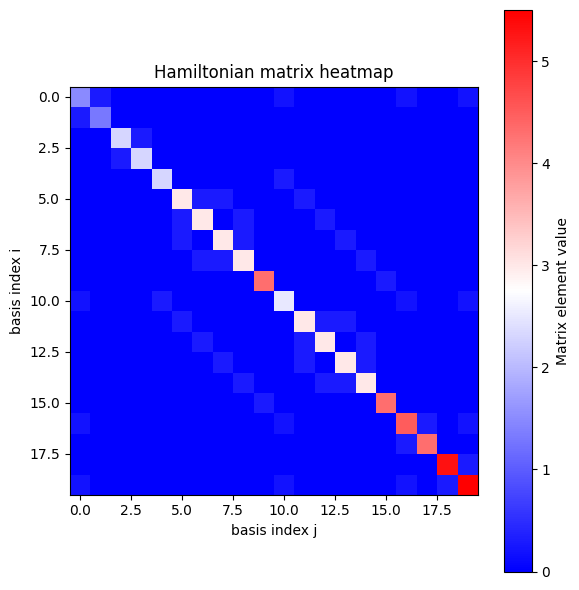

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(H, cmap="bwr", interpolation="nearest")
plt.colorbar(label="Matrix element value")
plt.title("Hamiltonian matrix heatmap")
plt.xlabel("basis index j")
plt.ylabel("basis index i")
plt.tight_layout()
plt.show()

In [4]:
import itertools
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

# --- パラメータ設定 ---
N_orb = 4  # 軌道数（例：4軌道）
np.random.seed(0)

# --- 1体・2体・3体の相互作用係数を定義（ランダム） ---
t = np.random.randn(N_orb, N_orb)
V2 = np.random.randn(N_orb, N_orb, N_orb, N_orb)
V3 = np.random.randn(N_orb, N_orb, N_orb, N_orb, N_orb, N_orb)

# --- FermionicOp 形式でHamiltonianを構築 ---
terms = {}

# 1体項: a†_i a_j
for i, j in itertools.product(range(N_orb), repeat=2):
    label = f"+_{i} -_{j}"
    terms[label] = terms.get(label, 0.0) + t[i, j]

# 2体項: a†_i a†_j a_l a_k
for i, j, k, l in itertools.product(range(N_orb), repeat=4):
    label = f"+_{i} +_{j} -_{l} -_{k}"
    terms[label] = terms.get(label, 0.0) + 0.25 * V2[i, j, k, l]

# 3体項: a†_i a†_j a†_k a_n a_m a_l
for i, j, k, l, m, n in itertools.product(range(N_orb), repeat=6):
    label = f"+_{i} +_{j} +_{k} -_{n} -_{m} -_{l}"
    terms[label] = terms.get(label, 0.0) + (1/36) * V3[i, j, k, l, m, n]

# Fermionic Hamiltonian operator
fermionic_ham = FermionicOp(terms, num_spin_orbitals=N_orb)

# --- Jordan-Wigner変換 ---
mapper = JordanWignerMapper()
qubit_ham = mapper.map(fermionic_ham)

# --- 結果の表示 ---
print("=== Fermionic Hamiltonian ===")
print(fermionic_ham)
print("\n=== Pauli-encoded Hamiltonian ===")
print(qubit_ham)

=== Fermionic Hamiltonian ===
Fermionic Operator
number spin orbitals=4, number terms=4368
  1.764052345967664 * ( +_0 -_0 )
+ 0.4001572083672233 * ( +_0 -_1 )
+ 0.9787379841057392 * ( +_0 -_2 )
+ 2.240893199201458 * ( +_0 -_3 )
+ 1.8675579901499675 * ( +_1 -_0 )
+ -0.977277879876411 * ( +_1 -_1 )
+ 0.9500884175255894 * ( +_1 -_2 )
+ -0.1513572082976979 * ( +_1 -_3 )
+ -0.10321885179355784 * ( +_2 -_0 )
+ 0.41059850193837233 * ( +_2 -_1 )
+ 0.144043571160878 * ( +_2 -_2 )
+ 1.454273506962975 * ( +_2 -_3 )
+ 0.7610377251469934 * ( +_3 -_0 )
+ 0.12167501649282841 * ( +_3 -_1 )
+ 0.44386323274542566 * ( +_3 -_2 )
+ 0.33367432737426683 * ( +_3 -_3 )
+ 0.37351976828940153 * ( +_0 +_0 -_0 -_0 )
+ -0.05128956594145022 * ( +_0 +_0 -_1 -_0 )
+ 0.07826692541272534 * ( +_0 +_0 -_2 -_0 )
+ -0.2135239348254312 * ( +_0 +_0 -_3 -_0 )
+ -0.6382474539585197 * ( +_0 +_0 -_0 -_1 )
+ 0.16340464886009015 * ( +_0 +_0 -_1 -_1 )
+ 0.21610904971487638 * ( +_0 +_0 -_2 -_1 )
+ -0.18554125510161043 * ( +_0 +_0 -_

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import EstimatorV2  # または qiskit_ibm_runtime のものを使う
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as RuntimeEstimatorV2
# 注意：どちらのパッケージを使うか環境に依存します

# --- ハミルトニアン（SparsePauliOp 型）を用意済みと仮定 ---
# 例: qubit_ham = SparsePauliOp.from_list([...]) または qiskit_nature から得たもの

n_qubits = qubit_ham.num_qubits

# --- パラメータ付き回路 (ansatz) ---
theta = Parameter("θ")
qc = QuantumCircuit(n_qubits)
qc.ry(theta, 0)
if n_qubits > 1:
    qc.cx(0, 1)

# --- EstimatorV2 を初期化 ---
# オンライン実機／シミュレータを使う場合
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=True)
estimator = RuntimeEstimatorV2(backend=backend)

# --- パラメータスイープで期待値を計算 ---
thetas = np.linspace(0, 2 * np.pi, 50)
energies = []

pubs = []
for t in thetas:
    pubs.append((qc, qubit_ham, [t]))

job = estimator.run(pubs)
result = job.result()

for i, t in enumerate(thetas):
    energies.append(result[i].data.evs[0])

# --- 結果を表示 ---
import matplotlib.pyplot as plt
plt.plot(thetas, energies, "o-")
plt.xlabel("θ [rad]")
plt.ylabel("⟨H⟩")
plt.title("VQE: Energy vs θ (EstimatorV2)")
plt.grid(True)
plt.show()

min_idx = int(np.argmin(energies))
print(f"Minimum energy = {energies[min_idx]:.6f} at θ = {thetas[min_idx]:.3f}")

ImportError: cannot import name 'EstimatorV2' from 'qiskit.primitives' (/Users/ritsu/Desktop/QFF/qiskit/lib/python3.14/site-packages/qiskit/primitives/__init__.py)